In [1]:
import numpy as np
from scipy.ndimage import convolve
import cobra
from cobra.io import load_model
import matplotlib.pyplot as plt

# load the textbook model
model = load_model("textbook")

## dFBA

#### methods

In [2]:
def perform_dfba(
    model, 
    initial_conditions, 
    kinetic_params, # (Km, Vmax)
    time_points, 
    biomass_reaction, 
    substrate_update_reactions, 
    dt, 
    biomass_identifier='biomass',
):
    """
    Perform dynamic FBA (dFBA) simulation.
    """
    results = {key: [value] for key, value in initial_conditions.items()}

    # Correctly initialize results dictionary for time points
    for key in results:
        for _ in range(1, len(time_points)):
            results[key].append(0)  # Pre-fill with 0 to match the length of time_points

    for t_i in range(1, len(time_points)):
        for substrate, reaction_id in substrate_update_reactions.items():
            Km, Vmax = kinetic_params[substrate]
            substrate_concentration = results[substrate][t_i-1]
            uptake_rate = Vmax * substrate_concentration / (Km + substrate_concentration)
            model.reactions.get_by_id(reaction_id).lower_bound = -uptake_rate

        solution = model.optimize()
        if solution.status == 'optimal':
            biomass_growth_rate = solution.fluxes[biomass_reaction]
            
            results[biomass_identifier][t_i] = results[biomass_identifier][t_i-1] + biomass_growth_rate * results[biomass_identifier][t_i-1] * dt

            for substrate, reaction_id in substrate_update_reactions.items():
                flux = solution.fluxes[reaction_id]
                results[substrate][t_i] = max(results[substrate][t_i-1] + flux * results[biomass_identifier][t_i-1] * dt, 0)
        else:
            for key in results.keys():
                results[key][t_i] = results[key][t_i-1]

    return results


def plot_dfba_results(time_points, dfba_results, title='dFBA Simulation Results'):
    """
    Plot the results of a dFBA simulation.

    Parameters:
    - time_points (list): A list of time points at which the simulation was evaluated.
    - dfba_results (dict): A dictionary containing time series data for biomass and external metabolites.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(8, 5))
    for key, values in dfba_results.items():
        plt.plot(time_points, values, label=key.capitalize())
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend()
    plt.show()


### example

/Users/eranagmon/code/bigraph-schema/venv/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


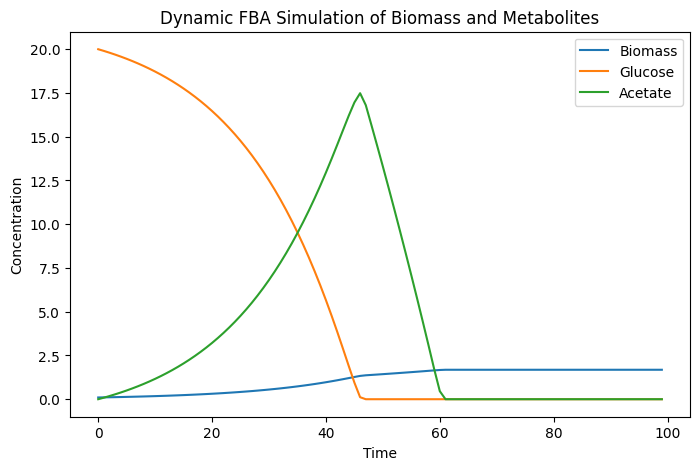

In [3]:
model.reactions.EX_o2_e.lower_bound = -2  # Limiting oxygen uptake
model.reactions.ATPM.lower_bound = 1     # Setting lower bound for ATP maintenance
model.reactions.ATPM.upper_bound = 1     # Setting upper bound for ATP maintenance

# Define initial conditions, kinetic parameters, and other necessary inputs
initial_conditions = {
    'biomass': 0.1,  # Initial biomass concentration
    'glucose': 20.0, # Initial glucose concentration
    'acetate': 0.0   # Initial acetate concentration
}
kinetic_params = {
    'glucose': (0.5, 2), # Km and Vmax for glucose
    'acetate': (0.5, 2)  # Km and Vmax for acetate
}
substrate_update_reactions = {
    'glucose': 'EX_glc__D_e',  # Exchange reaction ID for glucose
    'acetate': 'EX_ac_e'       # Exchange reaction ID for acetate
}

# simulation conditions
t_n = 100 # number of time points
dt = 0.5  # Time step, matching your setup
time_points = list(range(0, t_n))  # Simulation time points, matching your setup

# Make sure to adjust the perform_dfba function if needed to initialize result arrays with sufficient size
dfba_results = perform_dfba(
    model, 
    initial_conditions, 
    kinetic_params, 
    time_points, 
    'Biomass_Ecoli_core', 
    substrate_update_reactions, 
    dt,
    'biomass'
)

# visualize
plot_dfba_results(time_points, dfba_results, title='Dynamic FBA Simulation of Biomass and Metabolites')

## Multiple species

To simulate multiple species with dynamic FBA in a shared environment, you'll modify the environment based on the collective metabolism of all species. Each species will have its model, and their uptake rates will affect the shared external metabolite pools. Here's how you can set this up:

- **Initialization**: Create copies of the model for each species, adjusting pathways and kinetic parameters as necessary for each.
- **Shared Environment**: Manage external metabolite concentrations (like glucose and acetate) in a way that reflects their collective consumption and production by all species.
- **Simulation Loop**: For each time step, calculate the uptake and production rates for each species based on their individual models and the current state of the shared environment. Update the biomass of each species and the concentrations of shared external metabolites accordingly.

In [4]:
import copy

# Initialize models for each species
model_species_1 = model  # Assuming 'model' is your original model
model_species_2 = copy.deepcopy(model)  # Create a deep copy for the second species

# Assuming model_species_2 is the one to modify
glucose_import_reaction_id = 'EX_glc__D_e'  # Example reaction ID for glucose import
model_species_2.reactions.get_by_id(glucose_import_reaction_id).lower_bound = 0

#### methods

In [5]:
def update_shared_environment(initial_conditions, *species_results):
    """
    Update the shared environment based on the dFBA results of multiple species.
    Assumes results from perform_dfba include net changes in substrate concentrations.
    - initial_conditions: A dictionary of initial concentrations for substrates and biomass.
    - species_results: Variable number of dictionaries, each representing dFBA results for a species.
    """
    # Initialize changes dictionary to store net changes in substrates
    changes = {substrate: 0.0 for substrate in initial_conditions}

    # Calculate net changes for each shared substrate
    for substrate in changes:
        total_change = sum(result[substrate][-1] - initial_conditions[substrate] for result in species_results)
        changes[substrate] = total_change / len(species_results)

    # Update initial_conditions for the next iteration for shared substrates
    for substrate, change in changes.items():
        initial_conditions[substrate] = max(0, initial_conditions[substrate] + change)

    # Update the initial_conditions for the next iteration for biomass of each species
    for i, result in enumerate(species_results, start=1):
        biomass_key = f'biomass_species_{i}'
        if biomass_key in initial_conditions:
            initial_conditions[biomass_key] = result[biomass_key][-1]


def perform_multi_species_dfba(time_points, initial_conditions, species_list, dt):
    """
    Perform a multi-species dynamic FBA simulation.

    Parameters:
    - time_points (list): Simulation time points.
    - initial_conditions (dict): Initial conditions for biomass and substrates.
    - species_list (list of dicts): Each dict contains species-specific information and dFBA parameters.
    - dt (float): Timestep duration.

    The species_list dict format:
    {
        'model': model_object,  # The metabolic model for the species
        'kinetic_params': dict,  # {substrate: (Km, Vmax)}
        'substrate_update_reactions': dict,  # {substrate: reaction_id}
        'biomass_reaction': str,  # ID of the biomass reaction
        'biomass_identifier': str,  # Key in initial_conditions representing this species' biomass
    }
    """
    sim_results = {key: [value] for key, value in initial_conditions.items()}

    for t_i in range(1, len(time_points)):
        dfba_results = []

        # Perform dFBA for each species
        for species in species_list:
            dfba_result = perform_dfba(
                species['model'],
                initial_conditions,
                species['kinetic_params'],
                [0, dt],
                species['biomass_reaction'],
                species['substrate_update_reactions'],
                dt,
                species['biomass_identifier'],
            )
            dfba_results.append(dfba_result)
            
            # Update biomass in simulation results
            sim_results[species['biomass_identifier']].append(dfba_result[species['biomass_identifier']][-1])

        # Update the shared environment
        update_shared_environment(initial_conditions, *dfba_results)

        # Update substrate concentrations in simulation results
        for substrate in [k for k in initial_conditions.keys() if k not in ['biomass_species_1', 'biomass_species_2']]:
            sim_results[substrate].append(initial_conditions[substrate])

    return sim_results

#### example

In [6]:
# Set initial conditions for both species and the shared environment
initial_conditions = {
    'biomass_species_1': 0.1, 
    'biomass_species_2': 0.1,  # Initial biomass for each species
    'glucose': 20.0, 
    'acetate': 0.0  # Shared environment conditions
}

# Km and Vmax for both species
kinetic_params_species_1 = {
    'glucose': (0.5, 2), 
    'acetate': (0.5, 0.02)
}  
kinetic_params_species_2 = {
    'glucose': (0.5, 0.02), 
    'acetate': (0.05, 2)
}  # Different kinetic params for species 2

# which reactions are used
substrate_update_reactions_species_1 = {
    'glucose': 'EX_glc__D_e', 
    'acetate': 'EX_ac_e'
}
substrate_update_reactions_species_2 = {
    'glucose': 'EX_glc__D_e', 
    'acetate': 'EX_ac_e',
}

# Define shared time points and dt
t_n = 200 # number of time points
dt = 0.5  # Time step, matching your setup
time_points = list(range(0, t_n))  # Simulation time points, matching your setup


# Assuming model_species_1 and model_species_2 are defined and initialized elsewhere
species_info = [
    {
        'model': model_species_1,
        'kinetic_params': kinetic_params_species_1,
        'substrate_update_reactions': substrate_update_reactions_species_1,
        'biomass_reaction': 'Biomass_Ecoli_core',  # Example reaction ID, adjust as needed
        'biomass_identifier': 'biomass_species_1',
    },
    {
        'model': model_species_2,
        'kinetic_params': kinetic_params_species_2,
        'substrate_update_reactions': substrate_update_reactions_species_2,
        'biomass_reaction': 'Biomass_Ecoli_core',  # Example reaction ID, adjust as needed
        'biomass_identifier': 'biomass_species_2',
    },
]

# Call the perform_multi_species_dfba function with the specified parameters
multispecies_results = perform_multi_species_dfba(
    time_points=time_points,
    initial_conditions=initial_conditions,
    species_list=species_info,
    dt=dt
)

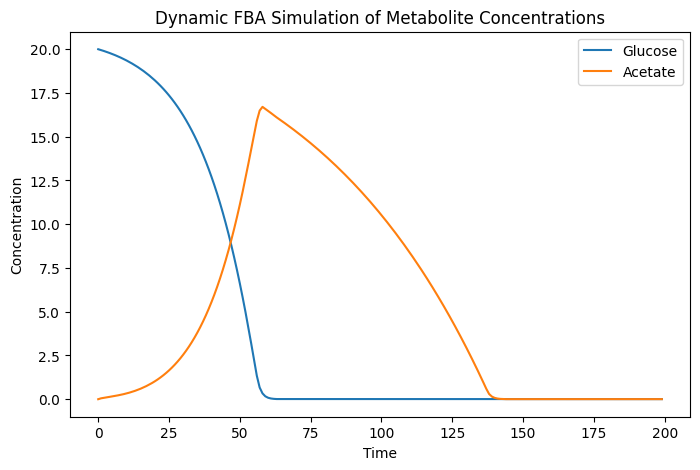

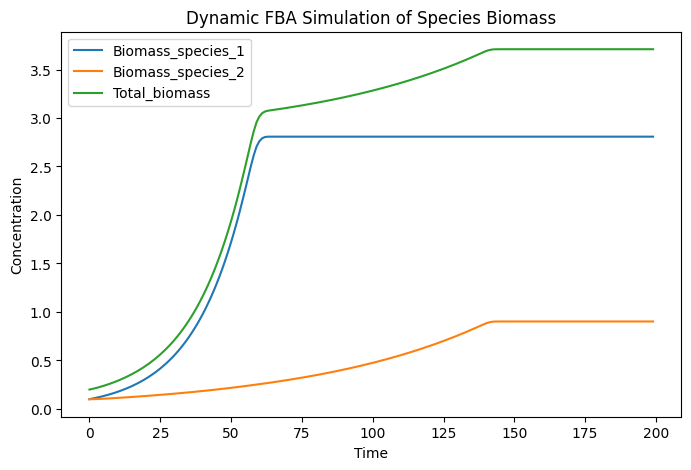

In [8]:
# plot metabolites
metabolite_results = {key: multispecies_results[key] for key in multispecies_results if key in ['glucose', 'acetate']}
plot_dfba_results(time_points, metabolite_results, title='Dynamic FBA Simulation of Metabolite Concentrations')

# plot biomass
biomass_results = {key: multispecies_results[key] for key in multispecies_results if 'biomass' in key}
total_biomass = [multispecies_results['biomass_species_1'][i] + multispecies_results['biomass_species_2'][i] for i in range(len(time_points))]
biomass_results['total_biomass'] = total_biomass

plot_dfba_results(time_points, biomass_results, title='Dynamic FBA Simulation of Species Biomass')

## 2D PDE Diffusion/Advection

#### methods

In [18]:
# Laplacian for 2D diffusion
LAPLACIAN_2D = np.array([[0,  1, 0],
                         [1, -4, 1],
                         [0,  1, 0]])

def generalized_advection_diffusion_2d(
    initial_states, 
    diffusion_coeffs, 
    advection_fields, 
    total_time, 
    dt,
):
    n_species = len(initial_states)
    current_states = [initial_state.copy() for initial_state in initial_states.values()]
    solutions = [[] for _ in initial_states]  # Initialize without copying initial state
    n_steps = int(total_time / dt)
    for step in range(n_steps + 1):  # +1 to include the last step
        for i in range(n_species):
            
            # Save current state
            solutions[i].append(current_states[i].copy())  

            # diffusion
            laplacian = convolve(
                current_states[i], 
                LAPLACIAN_2D, 
                mode='reflect', 
            ) * diffusion_coeffs[i]

            # advection
            advective_flux_x = convolve(
                current_states[i], 
                np.array([[-1, 0, 1]]), 
                # mode='reflect', 
            ) * advection_fields[i][0]
            advective_flux_y = convolve(
                current_states[i],
                np.array([[-1], [0], [1]]), 
                # mode='reflect', 
            ) * advection_fields[i][1]

            # update the current state
            current_states[i] += laplacian * dt + (advective_flux_x + advective_flux_y) * dt

            # Ensure non-negativity
            current_states[i] = np.maximum(current_states[i], 0)

    return solutions

def plot_species_distributions(solutions, times, titles):
    n_species = len(solutions)
    n_times = len(times)

    # Compute global min and max for each species
    global_min_max = [(np.min(sol), np.max(sol)) for sol in solutions]
    
    fig, axs = plt.subplots(n_times, n_species, figsize=(3*n_species, 3*n_times))
    for i, time in enumerate(times):
        for j in range(n_species):
            ax = axs[i, j] if n_times > 1 else axs[j]
            vmin, vmax = global_min_max[j]
            img = ax.imshow(solutions[j][int(time / dt)], interpolation='nearest', vmin=vmin, vmax=vmax)
            ax.set_title(f'{titles[j]} at Time = {time}s')
            plt.colorbar(img, ax=ax)
    plt.tight_layout()
    plt.show()

#### example

In [46]:
# Define the initial conditions, diffusion coefficients, and advection fields
# l1 = 20
# l2 = 10
# initial_state_1 = np.zeros((l1, l2))
# initial_state_1[int(l1/3)+1:int(2*l1/3),int(l2/3)+1:int(2*l2/3)]= 1

# initial_state_2 = np.zeros((l1, l2))
# initial_state_2[int(l1/3)+1:int(2*l1/3),int(l2/3)+1:int(2*l2/3)]= 1

# initial_states = {
#     's1': initial_state_1,
#     's2': initial_state_2,
#     's3': initial_state_2,
# }


width = 8
height = 10

acetate_field = np.zeros((height, width))

# Create a linear gradient from 1 to 0 vertically
vertical_gradient = np.linspace(1, 0, height).reshape(-1, 1)
glc_field = np.repeat(vertical_gradient, width, axis=1)

biomass_field = np.zeros((height, width))
biomass_field[1:2,:] = 1.0

initial_states = {
    'glucose': glc_field,
    'acetate': acetate_field,  
    'biomass': biomass_field,
}









# Diffusion for species 1 and species 2
diffusion_coeffs = [0.01, 0.01, 0.01]

# Advection for species 1 and species 2
advection_fields = [
    (0, 0.2), 
    (-0.1, -0.2),
    (0, 0.02)
]  

# Run the simulation
totaltime = 2000

advection_solutions = generalized_advection_diffusion_2d(
    initial_states, 
    diffusion_coeffs, 
    advection_fields, 
    total_time=totaltime, 
    dt=0.02, 
)

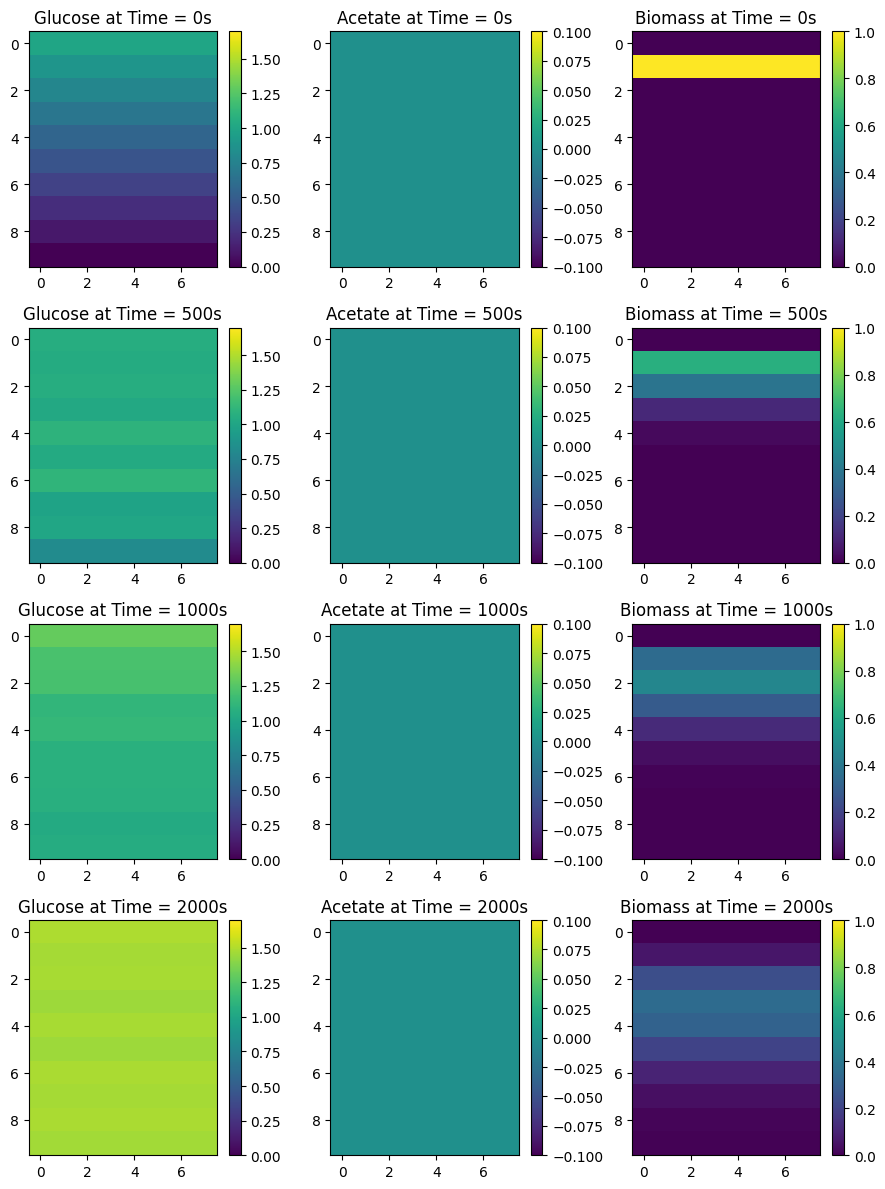

In [47]:
# Plot the results
plot_times=[0, int(totaltime/4), int(totaltime/2), totaltime]

plot_species_distributions(
    advection_solutions, 
    times=plot_times, 
    titles=['Glucose', 'Acetate', 'Biomass'])

In [19]:
# Define the initial conditions, diffusion coefficients, and advection fields
width = 8
height = 10

acetate_field = np.zeros((height, width))

# Create a linear gradient from 1 to 0 vertically
vertical_gradient = np.linspace(1, 0, height).reshape(-1, 1)
glc_field = np.repeat(vertical_gradient, width, axis=1)

biomass_field = np.zeros((height, width))
biomass_field[1:2,:] = 1.0

initial_states = {
    'glucose': glc_field,
    'acetate': acetate_field,  
    'biomass': biomass_field,
}

# Diffusion for species 1 and species 2
diffusion_coeffs = [
    0.01, 
    0.01, 
    0.0,
]

# Advection for species 1 and species 2
advection_fields = [
    (0, 0), 
    (0, 0),
    (1, 0),
]  

# Run the simulation
totaltime = 2000

advection_solutions = generalized_advection_diffusion_2d(
    initial_states, 
    diffusion_coeffs, 
    advection_fields, 
    total_time=totaltime, 
    dt=0.01, 
)

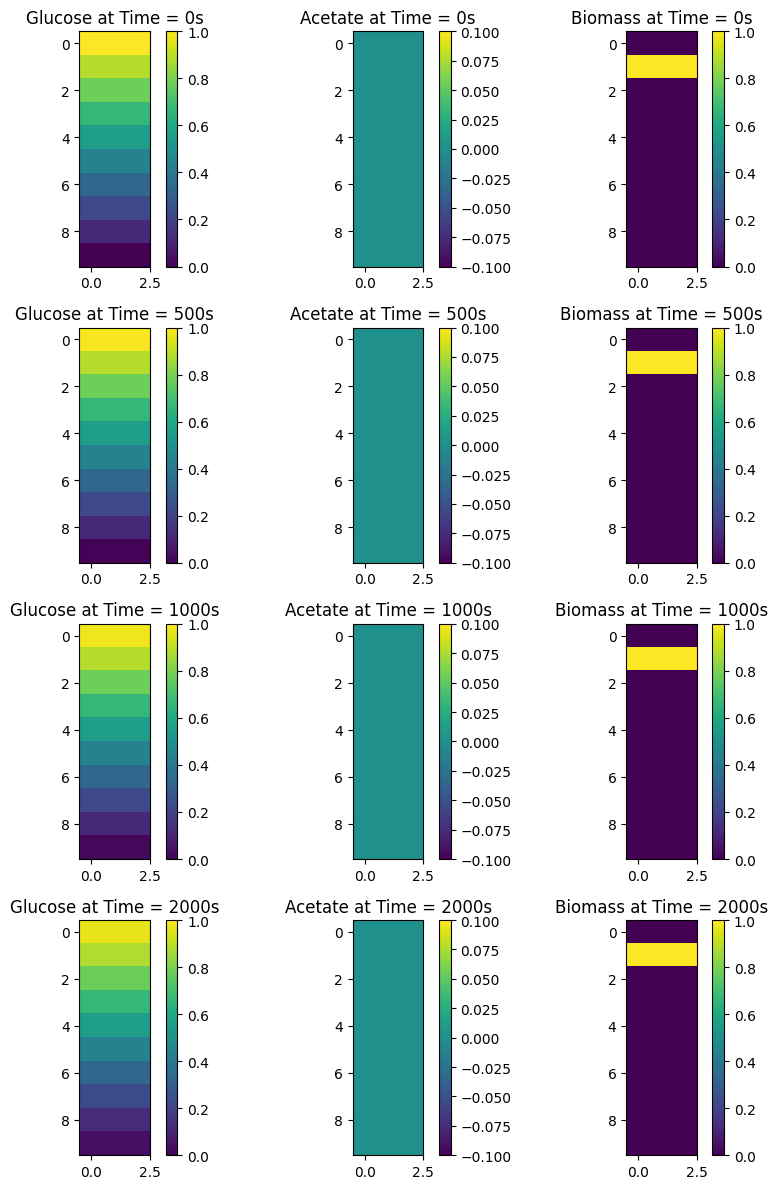

In [20]:
# Plot the results
plot_times=[0, int(totaltime/4), int(totaltime/2), totaltime]

plot_species_distributions(
    advection_solutions, 
    times=plot_times, 
    titles=['Glucose', 'Acetate', 'Biomass'])

## COMETS

In [26]:
def comets(initial_states, species_info, time_points, dt):
    """
    Perform a spatially resolved dFBA simulation on a grid.
    
    Parameters:
    - initial_states (list of np.arrays): Initial states for glucose, acetate, and biomass fields.
    - species_info (list of dicts): Information for each species for dFBA.
    - time_points (list): Time points for the simulation.
    - dt (float): Time step size.
    """
    # Unpack initial states for clarity
    glc_field, acetate_field, biomass_field = initial_states.values()

    height, width = glc_field.shape  # Assuming all fields have the same dimensions

    # Initialize fields to record changes
    updated_glc_field = np.zeros_like(glc_field)
    updated_acetate_field = np.zeros_like(acetate_field)
    updated_biomass_field = np.zeros_like(biomass_field)

    # Iterate through each grid site
    for y in range(height):
        for x in range(width):
            # Prepare initial conditions for the site
            initial_conditions = {
                'glucose': glc_field[y, x],
                'acetate': acetate_field[y, x],
                'biomass_species_1': biomass_field[y, x],  # Assuming one species for simplicity
                # Add 'biomass_species_2': value, if modeling multiple species
            }
            
            # Perform dFBA for the site
            sim_results = perform_multi_species_dfba(
                time_points, 
                initial_conditions, 
                species_info, 
                dt
            )
            
            # Update fields with the final state from dFBA results
            updated_glc_field[y, x] = sim_results['glucose'][-1]
            updated_acetate_field[y, x] = sim_results['acetate'][-1]
            updated_biomass_field[y, x] = sim_results['biomass_species_1'][-1]
            # Repeat for 'biomass_species_2' if modeling multiple species

    # Return the updated states
    return updated_glc_field, updated_acetate_field, updated_biomass_field


In [27]:
initial_states

{'glucose': array([[1.        , 1.        , 1.        ],
        [0.88888889, 0.88888889, 0.88888889],
        [0.77777778, 0.77777778, 0.77777778],
        [0.66666667, 0.66666667, 0.66666667],
        [0.55555556, 0.55555556, 0.55555556],
        [0.44444444, 0.44444444, 0.44444444],
        [0.33333333, 0.33333333, 0.33333333],
        [0.22222222, 0.22222222, 0.22222222],
        [0.11111111, 0.11111111, 0.11111111],
        [0.        , 0.        , 0.        ]]),
 'acetate': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'biomass': array([[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])}

In [33]:
# Define species_info and other required parameters as shown previously

species_info = [
    {
        'model': model_species_1,
        'kinetic_params': kinetic_params_species_1,
        'substrate_update_reactions': substrate_update_reactions_species_1,
        'biomass_reaction': 'Biomass_Ecoli_core',  # Example reaction ID, adjust as needed
        'biomass_identifier': 'biomass_species_1',
    },
    # {
    #     'model': model_species_2,
    #     'kinetic_params': kinetic_params_species_2,
    #     'substrate_update_reactions': substrate_update_reactions_species_2,
    #     'biomass_reaction': 'Biomass_Ecoli_core',  # Example reaction ID, adjust as needed
    #     'biomass_identifier': 'biomass_species_2',
    # },
]

# Call the comets function
comets_results = comets(
    initial_states, 
    species_info, 
    time_points, 
    dt
)

# # Access the updated fields
# updated_glc_field, updated_acetate_field, updated_biomass_field = updated_states


In [34]:
comets_results

(array([[1.        , 1.        , 1.        ],
        [0.        , 0.        , 0.        ],
        [0.77777778, 0.77777778, 0.77777778],
        [0.66666667, 0.66666667, 0.66666667],
        [0.55555556, 0.55555556, 0.55555556],
        [0.44444444, 0.44444444, 0.44444444],
        [0.33333333, 0.33333333, 0.33333333],
        [0.22222222, 0.22222222, 0.22222222],
        [0.11111111, 0.11111111, 0.11111111],
        [0.        , 0.        , 0.        ]]),
 array([[0.        , 0.        , 0.        ],
        [0.38302725, 0.38302725, 0.38302725],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]),
 array([[0.        , 0.        , 0.        ],
        [1.07657844, 1.0765784

TypeError: Invalid shape (3,) for image data

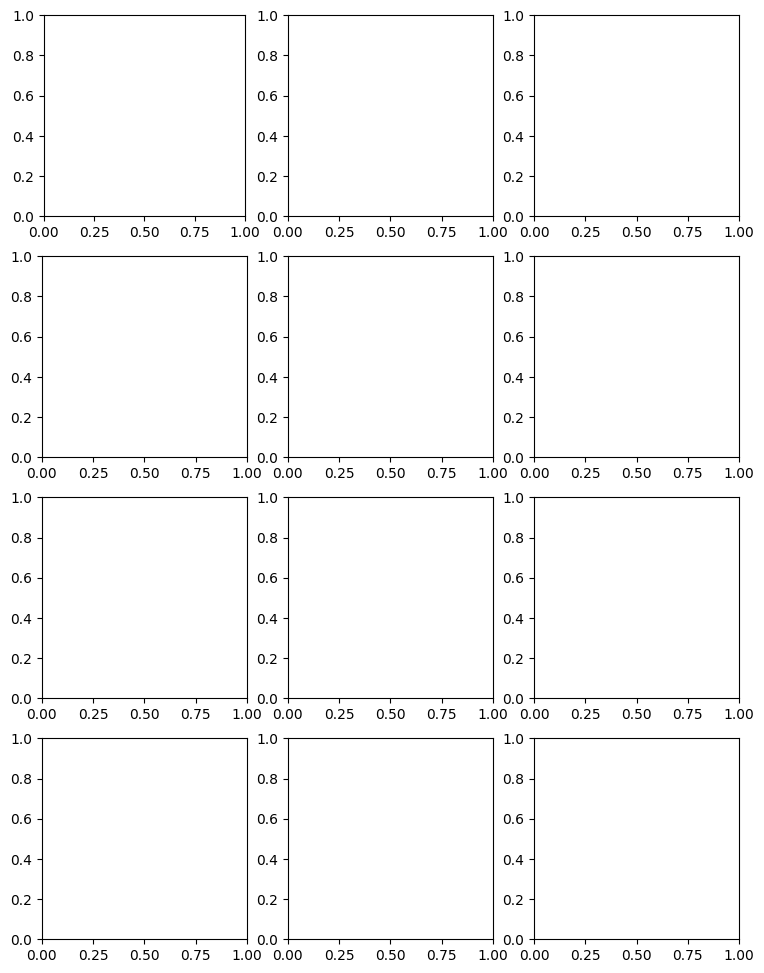

In [32]:
# Plot the results
plot_times=[0, int(totaltime/4), int(totaltime/2), totaltime]

plot_species_distributions(
    updated_states, 
    times=plot_times, 
    titles=['Glucose', 'Acetate', 'Biomass'])